# **< Temporary Sensing Paper Title >**

### Arni Sturluson, ...., Cory M. Simon

In [1]:
using CSV
using DataFrames
using PyPlot
using Printf
using LinearAlgebra
using Statistics

In this Notebook we will be analyzing the ability of different MOFs to sense CO<sub>2</sub> and SO<sub>2</sub> in an sensor array (i.e. e-nose) <br />
We will inspect the MOFs sensing capabilities using _Singular Value Decomposition_ (SVD) and eventually find an optimal pair of MOFs in our subset to use in a sensor array

MOF data was gathered from various sources. Henry coefficients were obtained by finding an initial slope of isotherms from those sources. See full citation list at the bottom of the notebook (or click [here](#ref_list))

| MOF | CO<sub>2</sub> Reference | SO<sub>2</sub> Reference |
| :--- |    :----:      | :----:         |
|MFM-600| 10.1021/jacs.8b08433 | 10.1021/jacs.8b08433 |
|MFM-601| 10.1021/jacs.8b08433 | 10.1021/jacs.8b08433 |
|Mg-MOF-74| 10.1021/cm401270b | 10.1002/aic.14467 |
|Ni(bdc)(ted)<sub>0.5</sub>| 10.1021/cm401270b | 10.1016/j.micromeso.2009.11.026 |
|Zn(bdc)(ted)<sub>0.5</sub>| 10.1021/cm401270b | 10.1016/j.micromeso.2009.11.026 |
|MFM-300(In)| 10.1002/adma.201602338 | 10.1002/adma.201602338 |
|NOTT-202a | 10.1021/ja401061m | 10.1021/ja401061m |
|NOTT-300 | 10.1038/nchem.1457 | 10.1038/nchem.1457 |
|Co[Co(CN)<sub>6</sub>]<sub>2</sub>&middot;_n_H<sub>2</sub>O | 10.1021/ic902397w | 10.1021/ic902397w |
|Zn[Co(CN)<sub>6</sub>]<sub>2</sub>&middot;_n_H<sub>2</sub>O | 10.1021/ic902397w | 10.1021/ic902397w |

In [2]:
global const df_henry = CSV.read("../data/henry_constants.csv")

,crystal,CO2_henry coefficient [mmol/(g-bar)],Temperature [K],SO2_henry coefficient [mmol/(g-bar)],Temperature [K]_1
,String⍰,Float64⍰,Int64⍰,Float64⍰,Int64⍰
1,MFM601,1.3703,298,97.2407,298
2,Zn-bdc-ted,2.15867,298,19.1696,298
3,Ni-bdc-ted,2.2069,298,40.402,298
4,NOTT-202a,3.27573,293,153.6,293
5,MFM600,1.41883,298,34.7973,298
6,NOTT-300,7.96526,293,483.864,293
7,MFM-300-In,4.60751,298,171.432,298
8,Zn-CN6,5.17058,298,4.36483,298
9,Mg-MOF-74,198.82,298,150.413,298


Lets see how the Henry coefficients are distributed. **<span style='color:red'>(Remove this?)</span>**

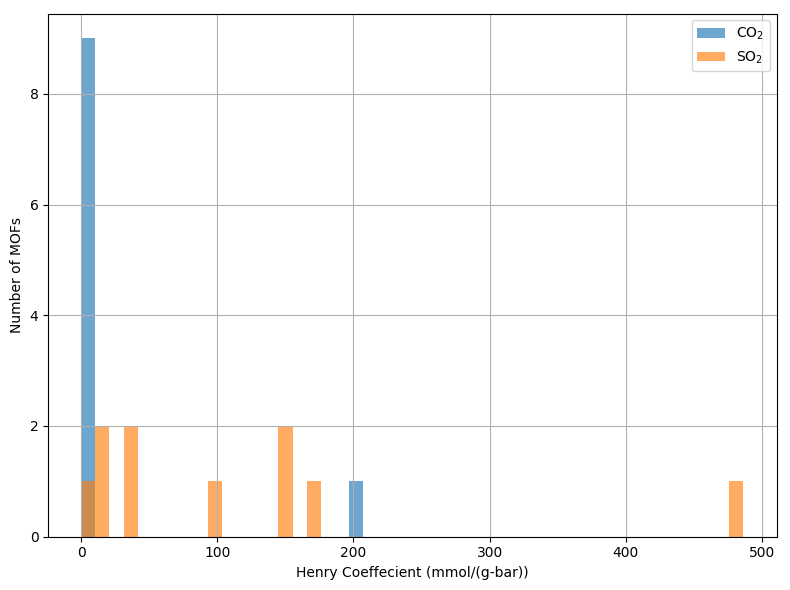

In [3]:
function plot_histogram()
    fig = figure(figsize=(8,6))
    gases = ["CO2", "SO2"]
    gas_labels = [L"CO$_2$", L"SO$_2$"]
    bin_size = 10.35
    maximum_value = maximum([maximum(df_henry[Symbol(gases[i] * "_henry coefficient [mmol/(g-bar)]")]) for i = 1:length(gases)])
    for (i, gas) in enumerate(gases)
        plt[:hist](df_henry[Symbol(gas * "_henry coefficient [mmol/(g-bar)]")], label=gas_labels[i],
            alpha=0.65, bins=range(0, stop=maximum_value + bin_size, step=bin_size))
    end
    legend()
    grid()
    xlabel("Henry Coeffecient (mmol/(g-bar))")
    ylabel("Number of MOFs")
    tight_layout()
    return
end
plot_histogram()

Here we lay down the groundwork for our SVD analysis<br />
We begin by constructing a matrix, **H**, containing the Henry coefficients for the gas-MOF pair we are interested in

In [4]:
construct_matrix(mofs::Array{Int64, 1}, gases::Array{<:AbstractString, 1}) = [df_henry[mof, Symbol(gas * "_henry coefficient [mmol/(g-bar)]")] for mof in mofs, gas in gases]
construct_matrix([7,9], ["SO2", "CO2"])

2×2 Array{Float64,2}:
 171.432    4.60751
 150.413  198.82   

In [5]:
function mof2index(mof::AbstractString)
    mask = mof .== df_henry[:crystal]
    if sum(mask) > 1
        @error "More than one MOF match the given MOF name"
    elseif sum(mask) == 0
        @error "No MOF matched the given MOF name"
    else
        return argmax(mask)
    end
end
mof1 = mof2index("MFM600")
mof2 = mof2index("Mg-MOF-74")
construct_matrix([mof1, mof2], ["SO2", "CO2"])

2×2 Array{Float64,2}:
  34.7973    1.41883
 150.413   198.82   

Lets look at the response generated by every combination of 2 MOFs from our subset of MOFs:

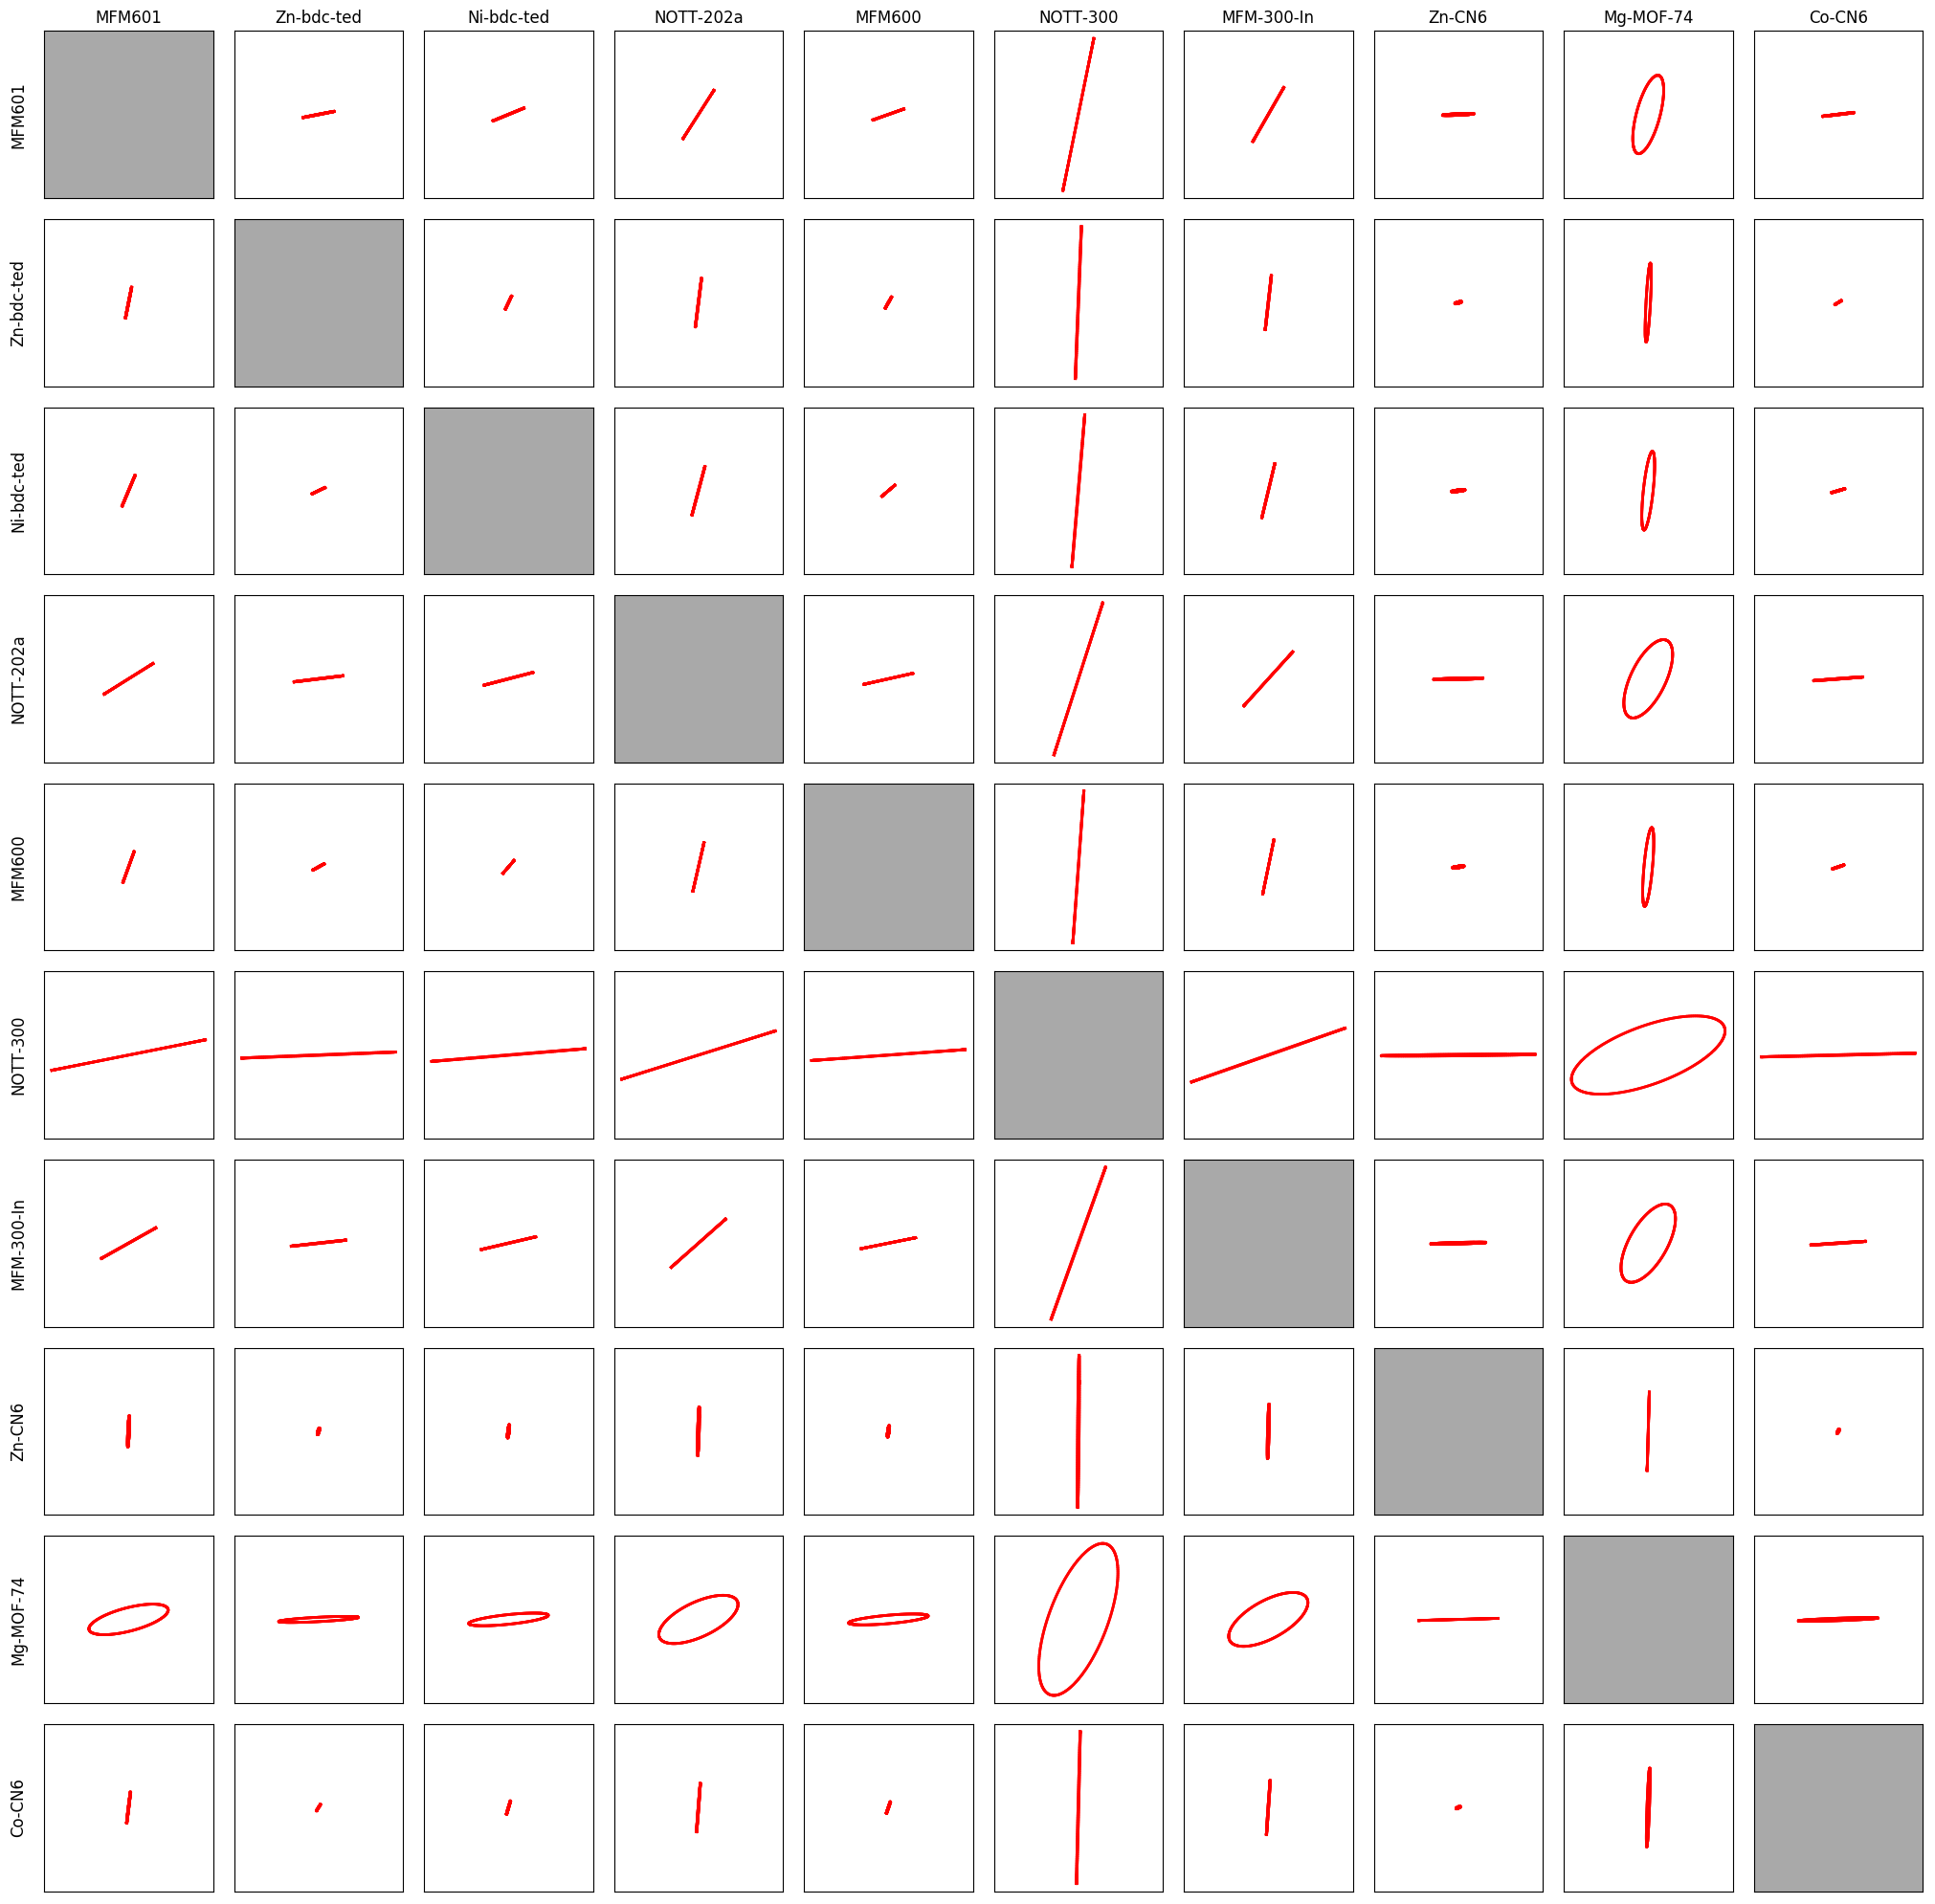

In [40]:
function plot_all_responses(gases::Array{<:AbstractString, 1}, plot_lower_triangular=false)
    n_mofs = length(df_henry[:crystal])
    fig, axs = plt[:subplots](nrows=n_mofs, ncols=n_mofs, figsize=(20, 20),
                              sharex=true, sharey=true)
    mof_no = 0
    for i = 1:n_mofs
        for j = 1:n_mofs

            # The response generated by having two of the same MOFs is an underdetermined problem with infinite solutions
            if i == j
                axs[i, j][:set_facecolor]("#a9a9a9")
                axs[i, j][:set_xticks]([])
                axs[i, j][:set_yticks]([])
                #axs[i, j][:axis]("off")
                #continue
            else
                
                if !plot_lower_triangular && (i > j)
                    axs[i, j][:axis]("off")
                    continue
                end
                    # Divide by a million to get ppm
                H = construct_matrix([i, j], gases)
                # Decompose `H` with SVD. `F` stores U, Σ, V and Vᵀ
                F = svd(H)
                # `θ` and `p` are used to plot a unit circle in composition space
                θ = range(0, stop=2*π, length=200)
                p = transpose(hcat(cos.(θ), sin.(θ)))
                # The matrix H maps the partial pressures `p` to a response `n`
                n = H * p
                for k in 1:length(θ)-1
                    axs[i,j][:plot](n[1, k:k+1], n[2, k:k+1], lw=2, c="r")
                end
                
            end
            
            if i == 1
                axs[i, j][:set_title](df_henry[:crystal][j])
            end
            if j == 1
                axs[i, j][:text](-750, 0, df_henry[:crystal][i], size=12, verticalalignment = "center", rotation = 90)
            end
            tight_layout()
            savefig("all_responses.png", format="png")
            show()
        end
    end
end
plot_all_responses(["SO2", "CO2"], true)

Lets see how a pair of MOFs respond to a change in gas concentration (or equivalently, partial pressure, assuming ideal gases) **<span style='color:red'>(Make sure this is correct)</span>**

In [6]:
function plot_response(mofs::Array{Int64, 1}, gases::Array{<:AbstractString, 1})
    # Divide by a million to get ppm
    H = construct_matrix(mofs, gases) ./ 1e6
    # Decompose `H` with SVD. `F` stores U, Σ, V and Vᵀ
    F = svd(H)
    # `θ` and `p` are used to plot a unit circle in composition space
    θ = range(0, stop=2*π, length=500)
    p = 4 .* transpose(hcat(cos.(θ), sin.(θ)))
    # The matrix H maps the partial pressures `p` to a response `n`
    n = H * p
    
    # A nested function to plot eigenvectors from the SVD decomposition
    #TODO Fix `head_width` to scale with response
    function plot_vector(x; width=0.001, head_length=0.05, head_width=0.05, color="k", label="", label_dist=0.05)
        x_plot = x - head_length * x / norm(x)
        arrow(0, 0, x_plot[1], x_plot[2], width=width, head_width=head_width,
            head_length=head_length, fc=color, ec=color, zorder=1000000)
        x_label = x + x / norm(x) * label_dist
        text(x_label[1], x_label[2], label)
    end

    cnorm = PyPlot.matplotlib[:colors][:Normalize](vmin=0.0, vmax=2 * π)
    m = plt[:cm][:ScalarMappable](norm=cnorm, cmap=plt[:cm][:hsv])
    m[:set_array]([])
    
    figure(figsize=(11, 5))
    # Composition Space
    subplot(121, aspect="equal")
    r = range(0.01, stop=1.0, length=50)
    
    for j in 1:length(r)
        p_bar = r[j] .* p
        scatter(p_bar[1, :], p_bar[2, :], lw=5, c=m[:to_rgba](θ))
        if mod(j,10) == 0
            for i in 1:length(θ)-1
                plot(p_bar[1, i:i+1], p_bar[2, i:i+1], lw=1, c="k", alpha=0.5)
            end
        end
    end
    
    #xlim([-1.1, 1.1])
    #ylim([-1.1, 1.1])
    axis("equal")
    xlabel(@sprintf("\$p_{%s}^*\$ (ppm)", gases[1]))
    ylabel(@sprintf("\$p_{%s}^*\$ (ppm)", gases[2]))
    for k = 1:2
        plot_vector(4 * F.V[:, k], color="k", head_width=0.35, head_length=0.25,
            label="\$\\mathbf{v}_$k\$", label_dist=0.5)
    end
    title("Composition Space")
    tight_layout()

    # Response Space
    subplot(122, aspect="equal")
    for i = 1:length(θ)-1
        plot(n[1, i:i+1], n[2, i:i+1], lw=5, c=m[:to_rgba](mean(θ[i:i+1])))
    end
    
    for j in 1:length(r)
        p_bar = r[j] .* p
        n_bar = H * p_bar
        scatter(n_bar[1, :], n_bar[2, :], lw=5, c=m[:to_rgba](θ))
        if mod(j,10) == 0
            for i in 1:length(θ)-1
                plot(n_bar[1, i:i+1], n_bar[2, i:i+1], lw=1, c="k", alpha=0.5)
            end
        end
    end

    
    for k = 1:2
        plot_vector(F.U[:, k] * F.S[k] * 4, head_length=0.000075, width=0.00001,
            head_width=0.000075, color="k", label="\$\\sigma_$k\\mathbf{u}_$k\$", label_dist=0.000075)
    end
    axis("equal")
    xlabel(@sprintf("\$n_{%s}^*\$ (change in mmol of total gas)", df_henry[:crystal][mofs[1]]))
    ylabel(@sprintf("\$n_{%s}^*\$ (change in mmol of total gas)", df_henry[:crystal][mofs[2]]))
    title("Response Space")
    tight_layout()
    savefig(@sprintf("composition_response_of_%i_and_%i.png", mofs[1], mofs[2]), format="png", dpi=300)
end

plot_response(mofs::Array{<:AbstractString, 1}, gases::Array{<:AbstractString, 1}) = plot_response(mof2index.(mofs), gases)

plot_response (generic function with 2 methods)

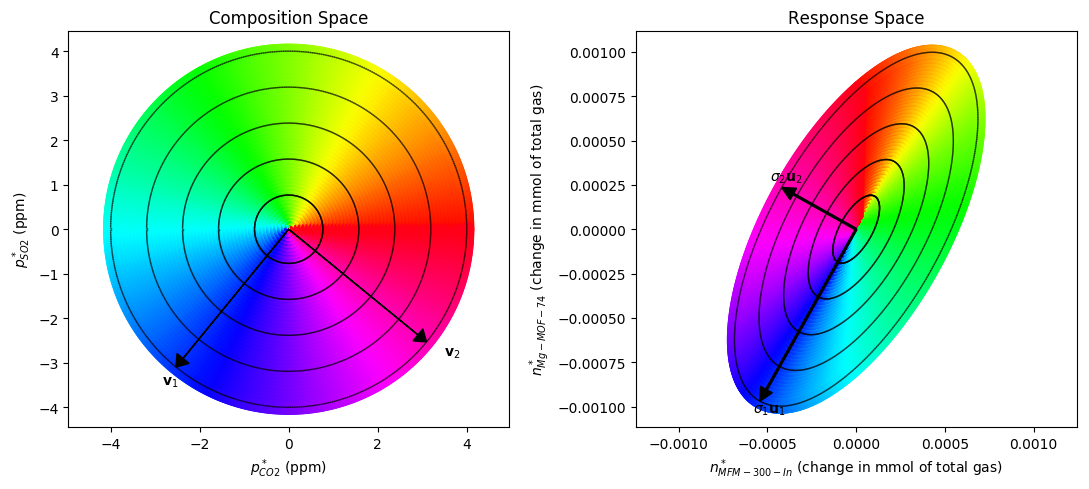

In [7]:
plot_response([7, 9], ["CO2", "SO2"])

<a id='ref_list'></a>
# **MOF References**
## MFM-600 & MFM-601
> Exceptional Adsorption and Binding of Sulfur Dioxide in a Robust Zirconium-Based Metal–Organic Framework<br />
Joseph H. Carter, Xue Han, Florian Y. Moreau, Ivan da Silva, Adam Nevin, Harry G. W. Godfrey, Chiu C. Tang, Sihai Yang, and Martin Schröder<br />
Journal of the American Chemical Society 2018 140 (46), 15564-15567<br />
DOI: 10.1021/jacs.8b08433
## MFM-300(In)
> Savage, M. , Cheng, Y. , Easun, T. L., Eyley, J. E., Argent, S. P., Warren, M. R., Lewis, W. , Murray, C. , Tang, C. C., Frogley, M. D., Cinque, G. , Sun, J. , Rudić, S. , Murden, R. T., Benham, M. J., Fitch, A. N., Blake, A. J., Ramirez‐Cuesta, A. J., Yang, S. and Schröder, M. (2016)<br />
Selective Adsorption of Sulfur Dioxide in a Robust Metal–Organic Framework Material<br />
Adv. Mater., 28: 8705-8711<br />
DOI: 10.1002/adma.201602338
## NOTT-202a
> Irreversible Network Transformation in a Dynamic Porous Host Catalyzed by Sulfur Dioxide<br />
Sihai Yang, Leifeng Liu, Junliang Sun, K. Mark Thomas, Andrew J. Davies, Michael W. George, Alexander J. Blake, Adrian H. Hill, Andrew N. Fitch, Chiu C. Tang, and Martin Schröder<br />
Journal of the American Chemical Society 2013 135 (13), 4954-4957<br />
DOI: 10.1021/ja401061m
## NOTT-300
> Selectivity and direct visualization of carbon dioxide and sulfur dioxide in a decorated porous host<br />
Sihai Yang, Junliang Sun, Anibal J. Ramirez-Cuesta, Samantha K. Callear, William I. F. David, Daniel P. Anderson, Ruth Newby, Alexander J. Blake, Julia E. Parker, Chiu C. Tang & Martin Schröder<br />
Nature Chemistry 2012 887 (4)<br />
DOI: 10.1038/nchem.1457
## Mg-MOF-74
> Mechanism of Preferential Adsorption of SO2 into Two Microporous Paddle Wheel Frameworks M(bdc)(ted)0.5<br />
Kui Tan, Pieremanuele Canepa, Qihan Gong, Jian Liu, Daniel H. Johnson, Allison Dyevoich, Praveen K. Thallapally, Timo Thonhauser, Jing Li, and Yves J. Chabal<br />
Chemistry of Materials 2013 25 (23), 4653-4662<br />
DOI: 10.1021/cm401270b

> Sun, W. , Lin, L. , Peng, X. and Smit, B. (2014), Computational screening of porous metal‐organic frameworks and zeolites for the removal of SO2 and NOx from flue gases.<br />
AIChE J., 60: 2314-2323.<br />
DOI: 10.1002/aic.14467
## Ni(bdc)(ted)<sub>0.5</sub> & Zn(bdc)(ted)<sub>0.5</sub>
> Mechanism of Preferential Adsorption of SO2 into Two Microporous Paddle Wheel Frameworks M(bdc)(ted)0.5<br />
Kui Tan, Pieremanuele Canepa, Qihan Gong, Jian Liu, Daniel H. Johnson, Allison Dyevoich, Praveen K. Thallapally, Timo Thonhauser, Jing Li, and Yves J. Chabal<br />
Chemistry of Materials 2013 25 (23), 4653-4662<br />
DOI: 10.1021/cm401270b

> CO2 adsorption, selectivity and water tolerance of pillared-layer metal organic frameworks <br />
> Zhijian Liang, Marc Marshall, Alan L. Chaffee<br />
Microporous and Mesoporous Materials 2010 132 (3), 305-310<br />
DOI: 10.1016/j.micromeso.2009.11.026
## Co[Co(CN)<sub>6</sub>]<sub>2</sub>&middot;<i>n</i>H<sub>2</sub>O & Zn[Co(CN)<sub>6</sub>]<sub>2</sub>&middot;<i>n</i>H<sub>2</sub>O
> Prussian Blue Analogues for CO2 and SO2 Capture and Separation Applications<br />
Praveen K. Thallapally, Radha Kishan Motkuri, Carlos A. Fernandez, B. Peter McGrail, and Ghorishi S. Behrooz<br />
Inorganic Chemistry 2010 49 (11), 4909-4915<br />
DOI: 10.1021/ic902397w